## Análise exploratória dos dados, treinamento, validação e teste da rede neural MLP no Dataset Titanic - Terceira Avaliação Redes Neurais
### Discente: João Pedro de Alcântara Lima

Neste trabalho, foi desenvolvido um pipeline completo de análise e modelagem preditiva utilizando o dataset do Titanic, com o objetivo de prever a sobrevivência dos passageiros a partir de variáveis disponíveis. O processo envolveu diversas etapas, desde a análise exploratória dos dados até a avaliação detalhada do desempenho do modelo de rede neural MLP.

#### 1. Análise Exploratória dos Dados

A análise exploratória foi fundamental para compreender a distribuição das variáveis e suas relações com a variável alvo (`Survived`). Foram geradas tabelas e gráficos para investigar a taxa de sobrevivência em função do sexo (`Sex`), classe (`Pclass`), idade (`Age`), local de embarque (`Embarked`), entre outros fatores. Observou-se, por exemplo, que mulheres e passageiros da primeira classe apresentaram maiores taxas de sobrevivência. Também foram analisadas as distribuições de variáveis como `SibSp`, `Parch`, `Fare` e `Cabin`, além de cruzamentos entre variáveis para identificar padrões e possíveis desbalanceamentos.

Contagem absoluta de sobreviventes por sexo:
Survived    0    1
Sex               
female     81  233
male      468  109

Percentual de sobreviventes por sexo:
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815


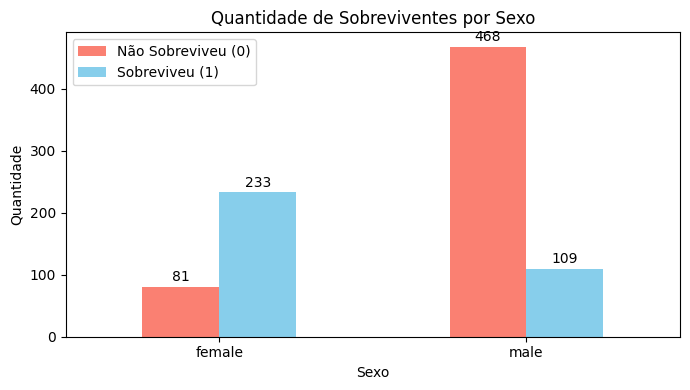

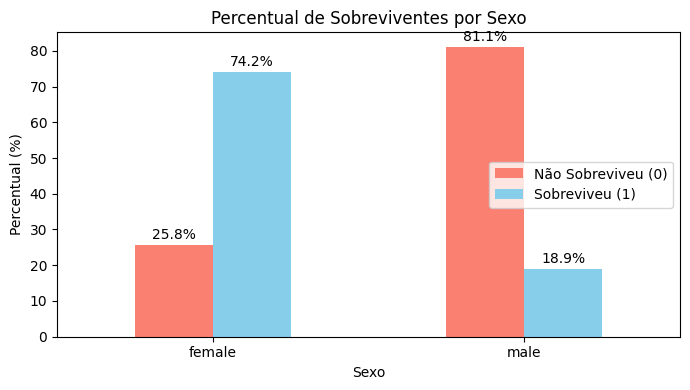

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 1. Análise quantitativa e relativa de Survived em relação ao Sex
survived_sex_counts = train_df.groupby('Sex')['Survived'].value_counts().unstack().fillna(0)
survived_sex_percent = survived_sex_counts.div(survived_sex_counts.sum(axis=1), axis=0) * 100

print("Contagem absoluta de sobreviventes por sexo:")
print(survived_sex_counts)
print("\nPercentual de sobreviventes por sexo:")
print(survived_sex_percent)

# Plotagem da quantidade absoluta
ax1 = survived_sex_counts.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Quantidade de Sobreviventes por Sexo')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax1.containers:
    ax1.bar_label(container, padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

# Plotagem do percentual
ax2 = survived_sex_percent.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Percentual de Sobreviventes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

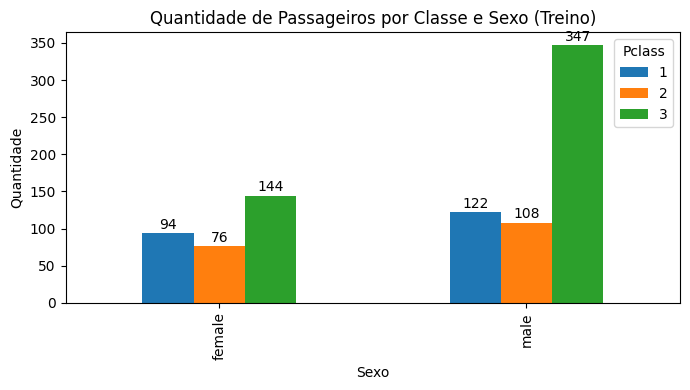

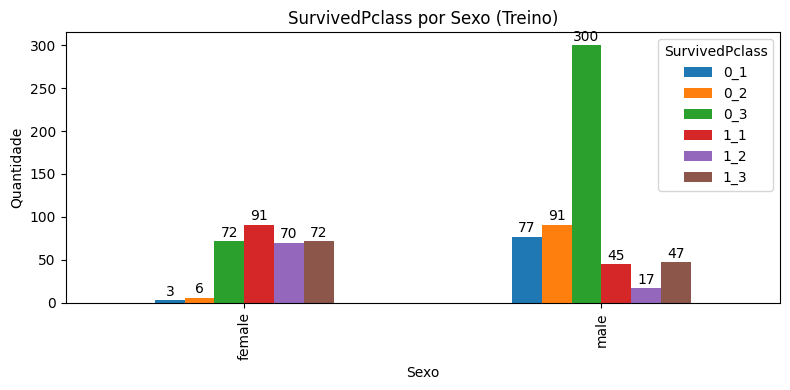

In [35]:
ct = pd.crosstab(train_df['Sex'], train_df['Pclass'])

fig, ax = plt.subplots(figsize=(7,4))
bars = ct.plot(kind='bar', ax=ax)

plt.title('Quantidade de Passageiros por Classe e Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

# 3. Criar a nova classe combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

ct = pd.crosstab(train_df['Sex'], train_df['SurvivedPclass'])

fig, ax = plt.subplots(figsize=(8,4))
bars = ct.plot(kind='bar', ax=ax)

plt.title('SurvivedPclass por Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='SurvivedPclass')
plt.tight_layout()
plt.show()

#### 2. Pré-processamento e Balanceamento das Classes

O pré-processamento incluiu a limpeza dos dados, tratamento de valores ausentes (como preenchimento de idades e tarifas faltantes com a mediana), e a codificação de variáveis categóricas. Em seguida, os dados foram divididos em conjuntos de treino (80%) e validação (20%), garantindo a estratificação da variável alvo. Para lidar com o desbalanceamento das classes, foi utilizado o método RandomOverSampler, que equilibrou as amostras das classes majoritária e minoritária no conjunto de treino, evitando viés do modelo.


#### 3. Treinamento, Validação e Ajuste de Hiperparâmetros da Rede Neural MLP

O modelo de rede neural MLP foi treinado com os dados balanceados e padronizados, utilizando uma camada oculta e diferentes configurações de hiperparâmetros. O ajuste fino dos hiperparâmetros foi realizado com GridSearchCV, testando diferentes tamanhos de camada oculta, funções de ativação e número de épocas. Durante o treinamento, foram monitoradas as curvas de loss (função de perda) tanto no treino quanto na validação, permitindo identificar o comportamento do modelo e possíveis sinais de overfitting ou underfitting.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


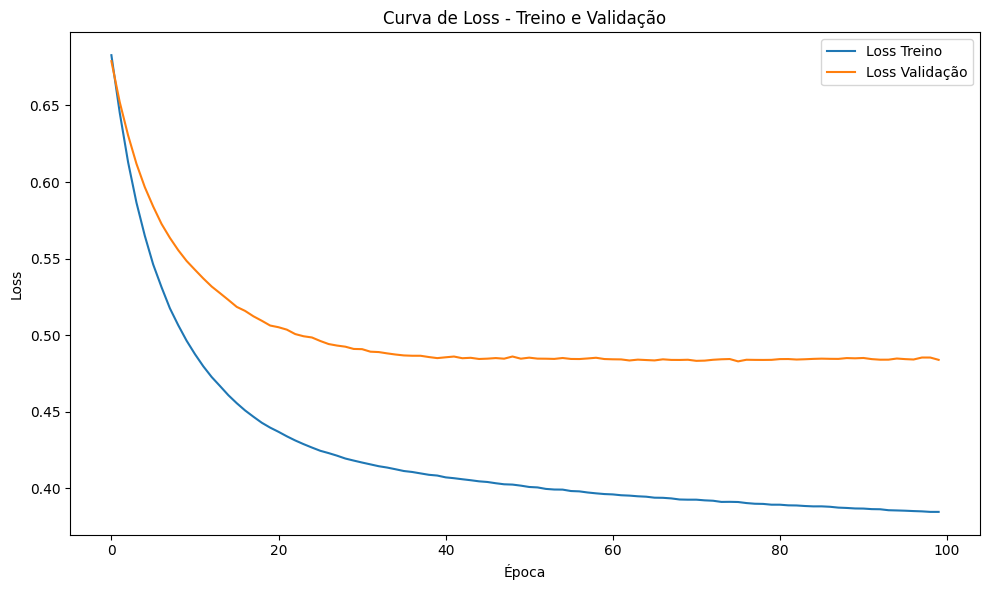

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History

# Seleção de features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train_df[features].copy()
y = train_df['Survived']

# Preenchimento dos valores ausentes
X['Age'] = X.groupby(['Pclass', 'Sex'])['Age'].transform(lambda grp: grp.fillna(grp.median()))
X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X.groupby(['Pclass', 'Embarked'])['Fare'].transform(lambda grp: grp.fillna(grp.median()))
X['Fare'] = X['Fare'].fillna(X['Fare'].median())

# Codificação de variáveis categóricas
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

# Divisão dos dados (70% treino, 20% teste e 10% validação)
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Modelo TensorFlow (MLP)
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=0
)

# Plot curva de treino e validação (loss)
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss - Treino e Validação')
plt.legend()
plt.tight_layout()
plt.show()

#### 4. Avaliação do Modelo

A avaliação do modelo foi conduzida no conjunto de validação, utilizando métricas como precisão, recall, F1-score e matriz de confusão. Também foi analisada a curva ROC e o valor da AUC para avaliar a capacidade discriminativa do modelo. Foram identificados os principais tipos de erro (falsos positivos e falsos negativos) e analisados exemplos concretos desses erros, além de calcular a acurácia segmentada por grupos, como sexo dos passageiros. A importância das variáveis foi avaliada a partir dos pesos da primeira camada da rede, destacando quais atributos mais influenciaram as decisões do modelo.

In [37]:
from sklearn.metrics import classification_report

# Avaliação no conjunto de validação
val_pred = model.predict(X_val_scaled)
val_pred = (val_pred > 0.5).astype(int).flatten()
print("Relatório de Classificação (Validação):")
print(classification_report(y_val, val_pred))

# Avaliação no conjunto de teste
test_pred = model.predict(X_test_scaled)
test_pred = (test_pred > 0.5).astype(int).flatten()
print("Relatório de Classificação (Teste):")
print(classification_report(y_test, test_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Relatório de Classificação (Validação):
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        55
           1       0.84      0.60      0.70        35

    accuracy                           0.80        90
   macro avg       0.81      0.76      0.77        90
weighted avg       0.81      0.80      0.79        90

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.82      0.94      0.87        99
           1       0.87      0.66      0.75        62

    accuracy                           0.83       161
   macro avg       0.84      0.80      0.81       161
weighted avg       0.84      0.83      0.83       161



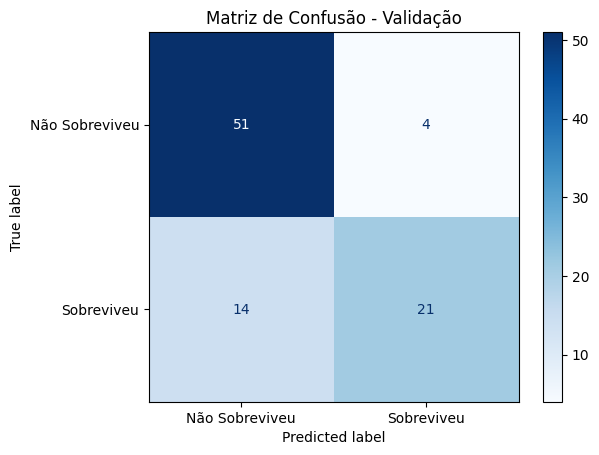

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão para o conjunto de validação
cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Sobreviveu', 'Sobreviveu'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Validação')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


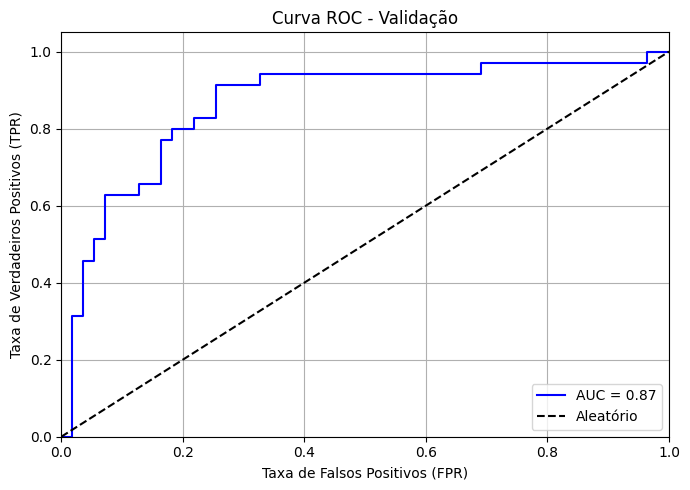

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


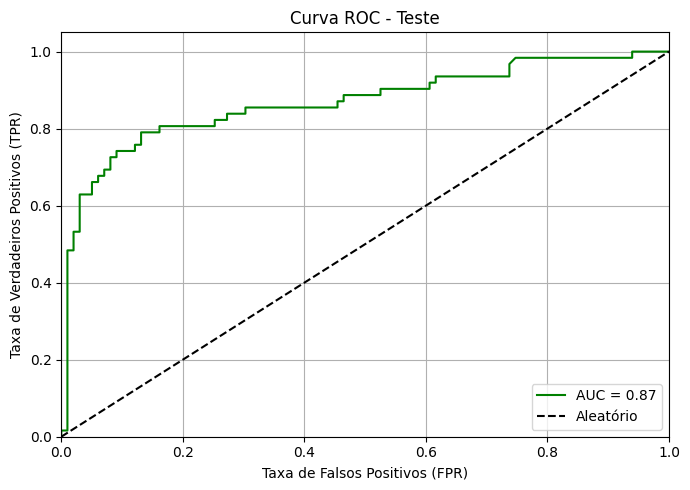

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Curva ROC para o conjunto de validação
y_val_proba = model.predict(X_val_scaled).flatten()
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Validação')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Curva ROC para o conjunto de teste
y_test_proba = model.predict(X_test_scaled).flatten()
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))
plt.plot(fpr_test, tpr_test, label=f'AUC = {roc_auc_test:.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Teste')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Regularização de Correlação no Treinamento da MLP

Neste trecho, foi implementada uma estratégia de regularização para reduzir o viés do modelo em relação à variável sensível `Fare`. Durante o treinamento do MLP, além do cálculo do loss padrão (`log_loss`), foram aplicadas duas formas de penalização baseadas na correlação entre as previsões do modelo e a feature sensível:

- **Loss Regularizado por Correlação:**  
  Em cada época, calcula-se a correlação de Pearson entre as probabilidades previstas pelo modelo e a variável `Fare`. Um termo de penalização proporcional a essa correlação (multiplicado por `lambda_corr`) é adicionado ao loss padrão, formando o loss regularizado. Isso incentiva o modelo a produzir previsões menos correlacionadas com a classe do passageiro.

- **Loss Ponderado por Correlação (`sample_weight`):**  
  Também foi calculado o loss ponderado, atribuindo pesos maiores às amostras mais distantes da média de `Pclass`. Isso força o modelo a prestar mais atenção em exemplos menos representados, reduzindo o viés.

Ao final, são plotadas as curvas de loss padrão, loss regularizado, loss ponderado, além das curvas de validação e teste, permitindo comparar o impacto da regularização de correlação no treinamento do modelo.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms

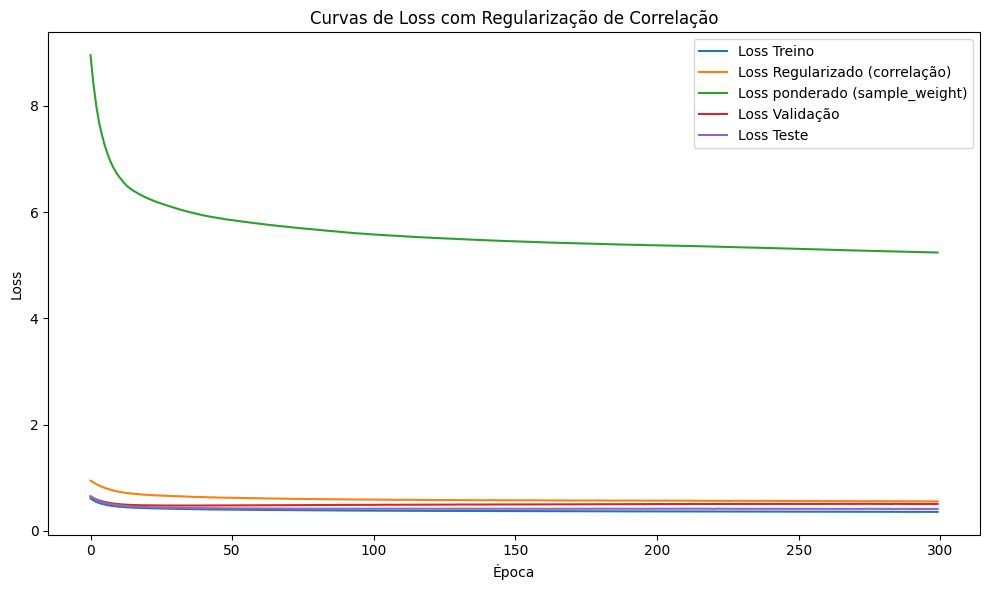

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Parâmetro de penalização
lambda_corr = 0.5

epochs = 300
train_losses = []
val_losses = []
test_losses = []
corr_penalties = []
loss_reg_list = []
loss_weighted_list = []

# sensitive_feature = X_train['Pclass'].values
sensitive_feature = X_train['Fare'].values

# Modelo TensorFlow (MLP)
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='sigmoid')
])
optimizer = Adam()

for epoch in range(epochs):
    # Treinamento por época
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    model.fit(X_train_scaled, y_train, epochs=1, batch_size=32, verbose=0)

    # Predições
    y_pred_proba = model.predict(X_train_scaled).flatten()

    # Loss padrão
    loss = tf.keras.losses.binary_crossentropy(y_train, y_pred_proba).numpy().mean()
    train_losses.append(loss)

    # Penalização por correlação
    corr, _ = pearsonr(y_pred_proba, sensitive_feature)
    reg_term = lambda_corr * np.abs(corr)
    corr_penalties.append(reg_term)

    # Loss regularizado
    loss_reg = loss + reg_term
    loss_reg_list.append(loss_reg)

    # Loss ponderado por correlação usando sample_weight
    sample_weight = 1 + lambda_corr * np.abs(sensitive_feature - sensitive_feature.mean())
    loss_weighted = tf.keras.losses.binary_crossentropy(y_train, y_pred_proba).numpy()
    loss_weighted = (loss_weighted * sample_weight).mean()
    loss_weighted_list.append(loss_weighted)

    # Loss validação e teste (sem regularização)
    val_pred_proba = model.predict(X_val_scaled).flatten()
    val_loss = tf.keras.losses.binary_crossentropy(y_val, val_pred_proba).numpy().mean()
    val_losses.append(val_loss)

    test_pred_proba = model.predict(X_test_scaled).flatten()
    test_loss = tf.keras.losses.binary_crossentropy(y_test, test_pred_proba).numpy().mean()
    test_losses.append(test_loss)

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Loss Treino')
plt.plot(loss_reg_list, label='Loss Regularizado (correlação)')
plt.plot(loss_weighted_list, label='Loss ponderado (sample_weight)')
plt.plot(val_losses, label='Loss Validação')
plt.plot(test_losses, label='Loss Teste')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curvas de Loss com Regularização de Correlação')
plt.legend()
plt.tight_layout()
plt.show()

1. **Correlação residual:** Calcula a correlação de Pearson entre as probabilidades previstas pelo modelo e os valores de `Fare`, permitindo avaliar se ainda existe viés nas predições em relação ao valor da passagem.

2. **Relatórios de classificação por faixas de Fare:** Divide os passageiros em quartis de `Fare` (Baixo, Médio-Baixo, Médio-Alto, Alto) e gera um relatório de classificação para cada grupo, mostrando precisão, recall e f1-score. Isso permite verificar se o modelo está performando de forma justa entre diferentes faixas de valor de passagem.

3. **Matriz de confusão segmentada:** Para cada faixa de `Fare`, é gerada uma matriz de confusão, facilitando a visualização dos tipos de erro cometidos pelo modelo em cada grupo.

4. **Curva ROC por faixa de Fare:** Plota curvas ROC separadas para cada faixa de `Fare`, comparando a capacidade discriminativa do modelo entre os diferentes grupos e exibindo o valor da AUC para cada um.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Correlação de Pearson entre predição e Fare (teste): 0.4636

Relatório de Classificação para Fare = Baixo:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        35
           1       0.80      0.36      0.50        11

    accuracy                           0.83        46
   macro avg       0.81      0.67      0.70        46
weighted avg       0.82      0.83      0.80        46


Relatório de Classificação para Fare = Médio-Baixo:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       0.88      0.64      0.74        11

    accuracy                           0.86        37
   macro avg       0.87      0.80      0.82        37
weighted avg       0.87      0.86      0.86        37


Relatório de Classificação para Fare = Médio-Alto:
              precision    recall  f1-score   support

           0       0.78      1.00      0.

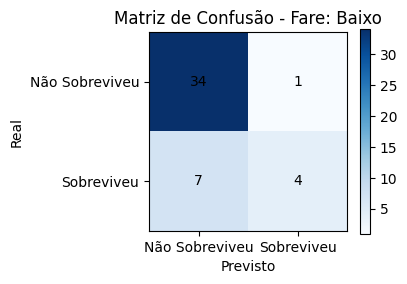

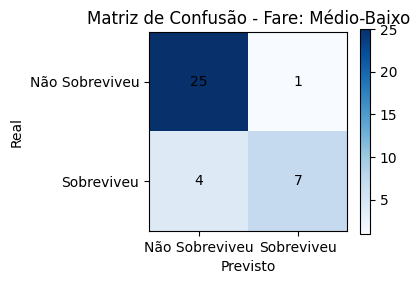

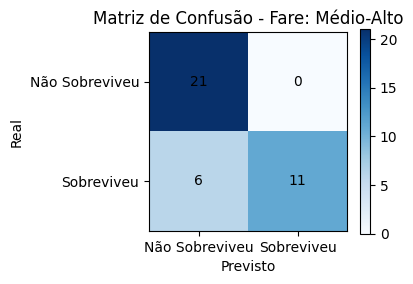

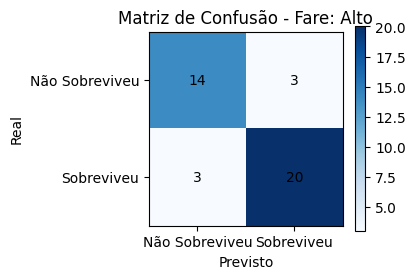

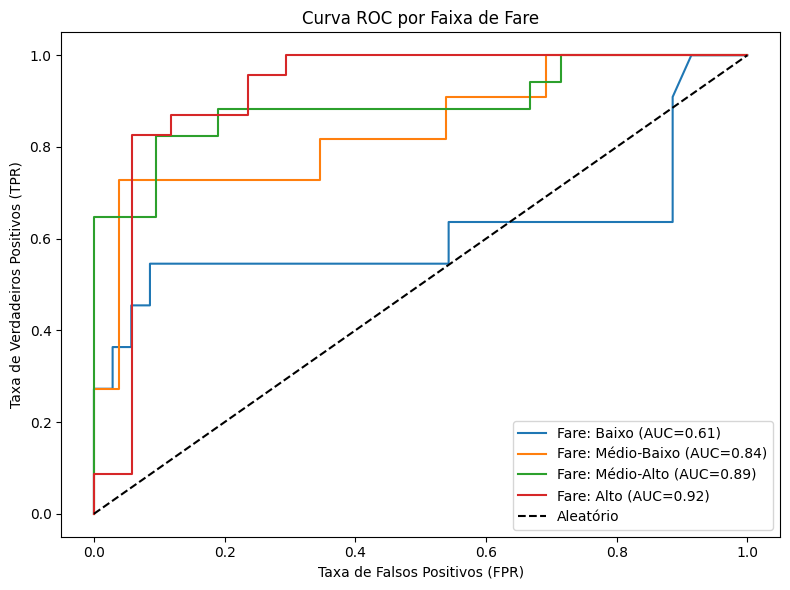

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Usando modelo TensorFlow
y_test_pred_proba = model.predict(X_test_scaled).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# 1. Correlação residual entre predições e Fare no teste
corr_test, _ = pearsonr(y_test_pred_proba, X_test['Fare'].values)
print(f"Correlação de Pearson entre predição e Fare (teste): {corr_test:.4f}")

# 2. Métricas por faixas de Fare (quartis)
fare_bins = pd.qcut(X_test['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0:
        print(f"\nRelatório de Classificação para Fare = {label}:")
        print(classification_report(y_test[idx], y_test_pred[idx]))
    else:
        print(f"\nNenhum exemplo para Fare = {label}")

# 3. Matriz de confusão segmentada por faixa de Fare
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0:
        cm = confusion_matrix(y_test[idx], y_test_pred[idx])
        plt.figure(figsize=(4,3))
        plt.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.title(f'Matriz de Confusão - Fare: {label}')
        plt.xlabel('Previsto')
        plt.ylabel('Real')
        plt.colorbar()
        plt.xticks([0,1], ['Não Sobreviveu', 'Sobreviveu'])
        plt.yticks([0,1], ['Não Sobreviveu', 'Sobreviveu'])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nNenhum exemplo para Fare = {label} (matriz de confusão)")

# 4. Curva ROC por faixa de Fare
plt.figure(figsize=(8,6))
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0 and sum(y_test[idx]) > 0 and sum(~idx) > 0:
        fpr, tpr, _ = roc_curve(y_test[idx], y_test_pred_proba[idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Fare: {label} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.title('Curva ROC por Faixa de Fare')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend()
plt.tight_layout()
plt.show()

#### Mitigação de Viés com Fairlearn usando Pclass, Sex_male e Parch como Features Sensíveis

Neste trecho, foi utilizada a biblioteca Fairlearn para mitigar o viés do modelo em relação às variáveis sensíveis `Pclass` (classe social do passageiro), `Sex_male` (sexo masculino) e `Parch` (número de pais/filhos do passageiro). O método `ExponentiatedGradient` foi aplicado sobre um modelo de regressão logística, com restrição de paridade demográfica (`DemographicParity`). Após o treinamento, o modelo foi avaliado quanto à taxa de seleção por grupo de cada atributo sensível, permitindo analisar se o modelo está tomando decisões mais justas entre diferentes classes de passageiros, gêneros e grupos familiares.

Além disso, foram gerados gráficos de importância das features do modelo Fairlearn, destacando quais variáveis mais influenciaram as decisões do modelo após a mitigação de viés. Esse processo permite comparar o impacto da penalização de viés sobre as variáveis e avaliar a equidade do modelo em diferentes cenários.


--- Usando 'Pclass' como atributo sensível ---


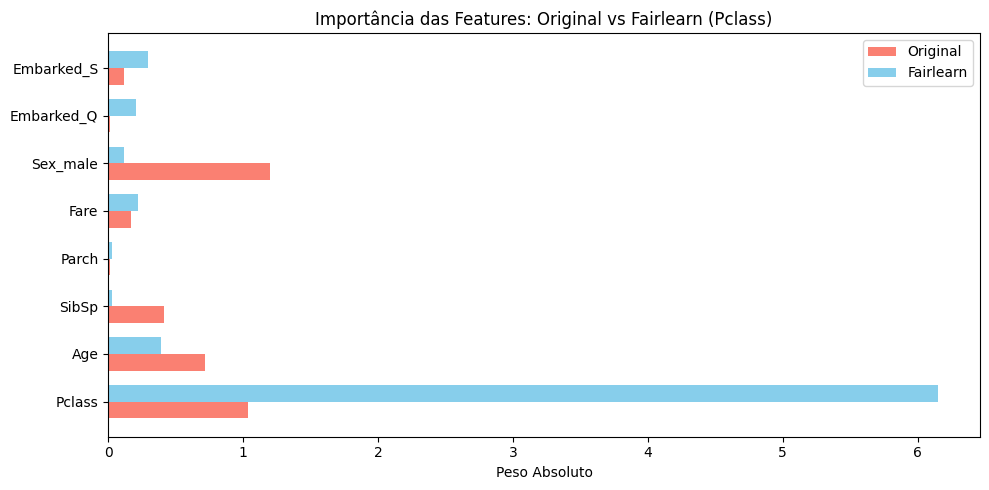

Relatório de Classificação - Modelo Fairlearn (Pclass):
              precision    recall  f1-score   support

           0       0.76      0.88      0.82        99
           1       0.74      0.56      0.64        62

    accuracy                           0.76       161
   macro avg       0.75      0.72      0.73       161
weighted avg       0.76      0.76      0.75       161


--- Usando 'Sex_male' como atributo sensível ---


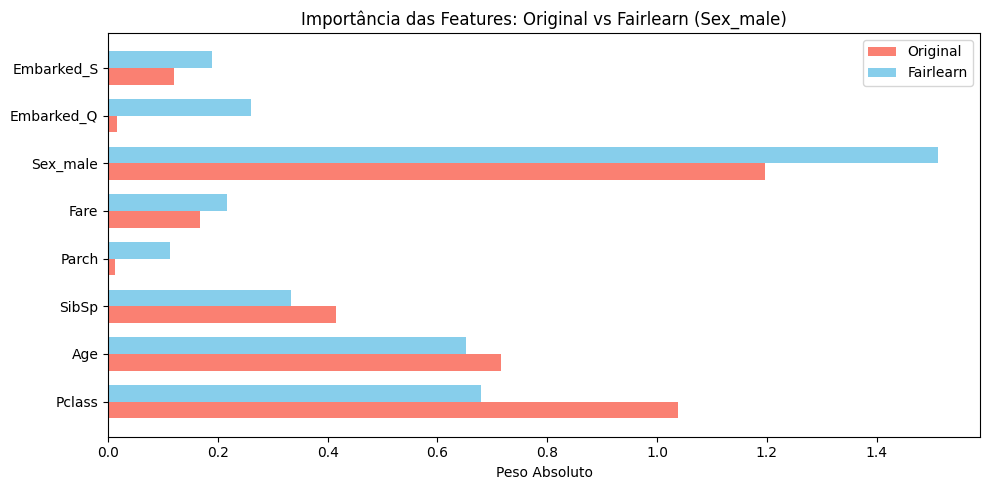

Relatório de Classificação - Modelo Fairlearn (Sex_male):
              precision    recall  f1-score   support

           0       0.64      0.79      0.71        99
           1       0.47      0.31      0.37        62

    accuracy                           0.60       161
   macro avg       0.56      0.55      0.54       161
weighted avg       0.58      0.60      0.58       161


--- Usando 'Parch' como atributo sensível ---


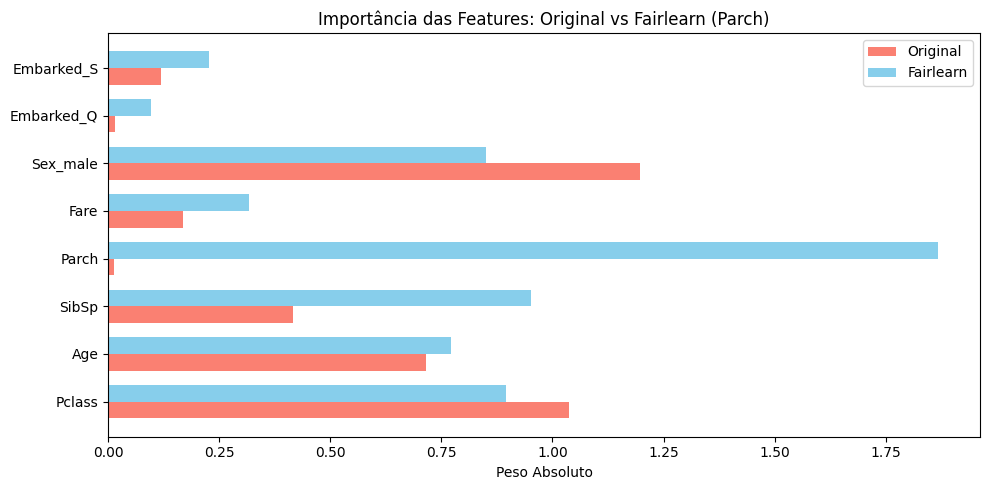

Relatório de Classificação - Modelo Fairlearn (Parch):
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        99
           1       0.48      0.44      0.46        62

    accuracy                           0.60       161
   macro avg       0.57      0.57      0.57       161
weighted avg       0.60      0.60      0.60       161



In [42]:
# Instale o fairlearn antes de importar
!pip install fairlearn

from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Função para treinar, avaliar e plotar com atributo sensível escolhido
def fairlearn_analysis(sensitive_col_name, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    print(f"\n--- Usando '{sensitive_col_name}' como atributo sensível ---")
    sensitive_feature = X_train[sensitive_col_name].values

    # Modelo original
    orig_model = LogisticRegression(solver='liblinear')
    orig_model.fit(X_train_scaled, y_train)
    orig_importances = np.abs(orig_model.coef_[0])
    orig_feature_names = X_train.columns

    # Modelo Fairlearn
    constraint = DemographicParity()
    base_estimator = LogisticRegression(solver='liblinear')
    mitigator = ExponentiatedGradient(
        base_estimator,
        constraints=constraint
    )
    mitigator.fit(X_train_scaled, y_train, sensitive_features=sensitive_feature)

    # Importância das features do modelo Fairlearn
    if hasattr(mitigator, 'predictor_'):
        fairlearn_importances = np.abs(mitigator.predictor_.coef_[0])
    elif hasattr(mitigator, 'predictors_') and len(mitigator.predictors_) > 0:
        last_predictor = mitigator.predictors_.iloc[-1]
        fairlearn_importances = np.abs(last_predictor.coef_[0])
    else:
        fairlearn_importances = np.zeros_like(orig_importances)
    fairlearn_feature_names = X_train.columns

    # Plot comparativo lado a lado
    x = np.arange(len(orig_feature_names))
    width = 0.35

    plt.figure(figsize=(10,5))
    plt.barh(x - width/2, orig_importances, height=width, color='salmon', label='Original')
    plt.barh(x + width/2, fairlearn_importances, height=width, color='skyblue', label='Fairlearn')
    plt.yticks(x, orig_feature_names)
    plt.title(f'Importância das Features: Original vs Fairlearn ({sensitive_col_name})')
    plt.xlabel('Peso Absoluto')
    plt.legend()
    plt.tight_layout()
    plt.show()

    y_test_pred_fair = mitigator.predict(X_test_scaled)
    print(f"Relatório de Classificação - Modelo Fairlearn ({sensitive_col_name}):")
    print(classification_report(y_test, y_test_pred_fair))

# Análise com Pclass
fairlearn_analysis('Pclass', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# Análise com Sex_male
fairlearn_analysis('Sex_male', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# Análise com Parch
fairlearn_analysis('Parch', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

#### Comparação dos Resultados: Pclass, Sex_male e Parch como Features Sensíveis

Ao aplicar a mitigação de viés com Fairlearn usando diferentes atributos sensíveis (`Pclass`, `Sex_male` e `Parch`), é possível observar como o modelo responde à restrição de paridade demográfica para cada grupo.

- **Pclass:** O modelo busca decisões mais justas entre diferentes classes de passageiros, reduzindo o impacto dessa variável nas previsões. O desempenho do modelo Fairlearn tende a permanecer próximo ao do modelo original, mostrando que é possível promover justiça sem grande perda de acurácia.
- **Sex_male:** Como o sexo é uma variável fortemente associada à sobrevivência no Titanic, a restrição pode causar uma redução mais significativa na acurácia e nas métricas de classificação. O modelo Fairlearn penaliza o uso excessivo do sexo, promovendo maior equidade entre homens e mulheres.
- **Parch:** Ao usar o número de parentes/acompanhantes a bordo como atributo sensível, o Fairlearn busca decisões mais equilibradas entre diferentes grupos familiares. Isso pode revelar possíveis disparidades nas previsões entre passageiros que viajavam sozinhos ou acompanhados, promovendo maior justiça entre esses grupos.

Comparando os resultados, é possível avaliar qual atributo sensível gera maior equilíbrio entre justiça e performance, e qual deles o modelo tende a depender mais para tomar decisões. Essa análise auxilia na escolha da melhor estratégia de mitigação de viés, considerando o contexto do problema e os objetivos de equidade.

#### 5. Testes e Análises Adicionais

Após a validação, o modelo foi aplicado ao conjunto de teste para prever a sobrevivência dos passageiros. Diversas análises complementares foram realizadas, como a identificação das cabines com maior proporção de sobreviventes, locais de embarque mais favoráveis em cada classe, e faixas de preço da passagem (`Fare`) e idade (`Age`) que mais impactaram a sobrevivência. Foram gerados gráficos para visualizar a influência dessas variáveis e entender melhor o comportamento do modelo. Por fim, foram analisados os erros do modelo por meio de heatmaps e contagens, permitindo identificar padrões nos casos em que o modelo apresentou maior dificuldade.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


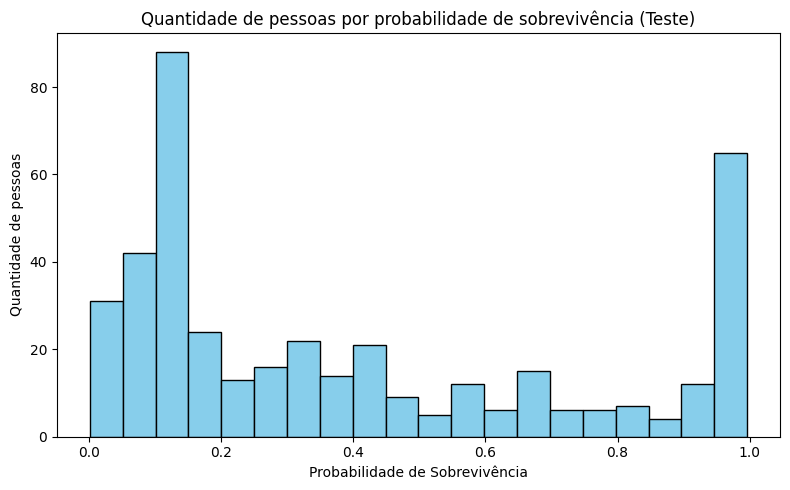

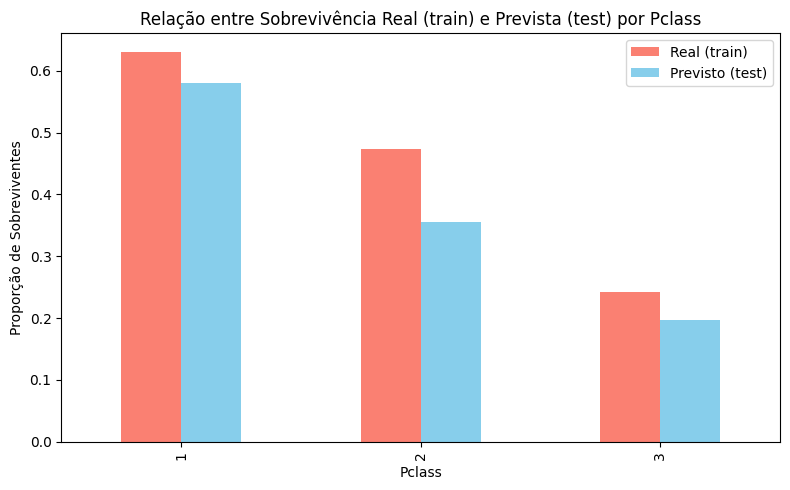

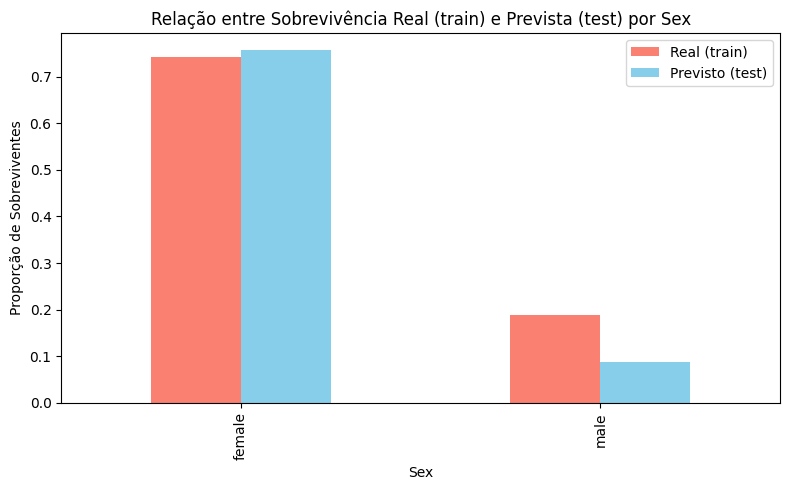

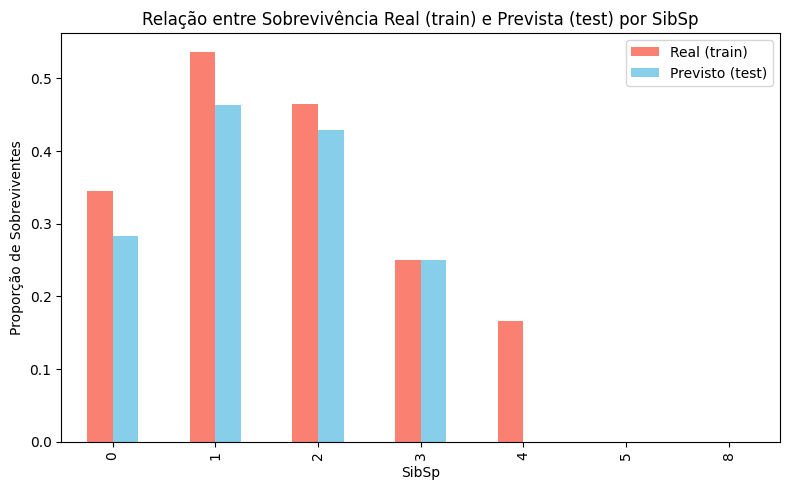

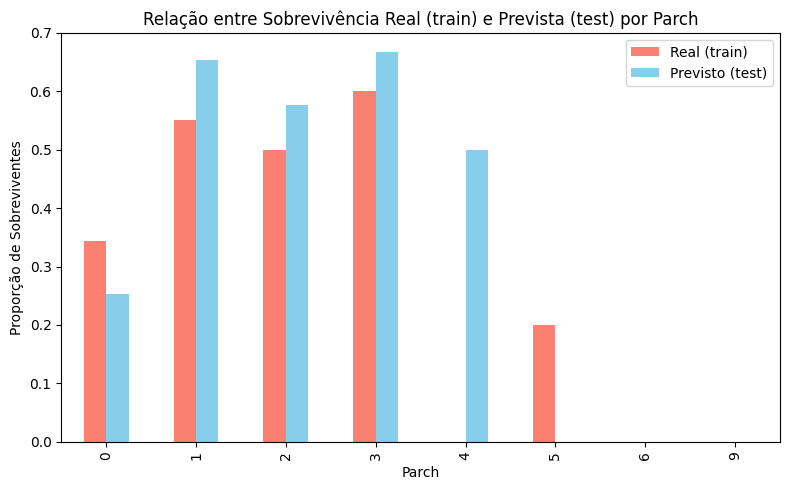

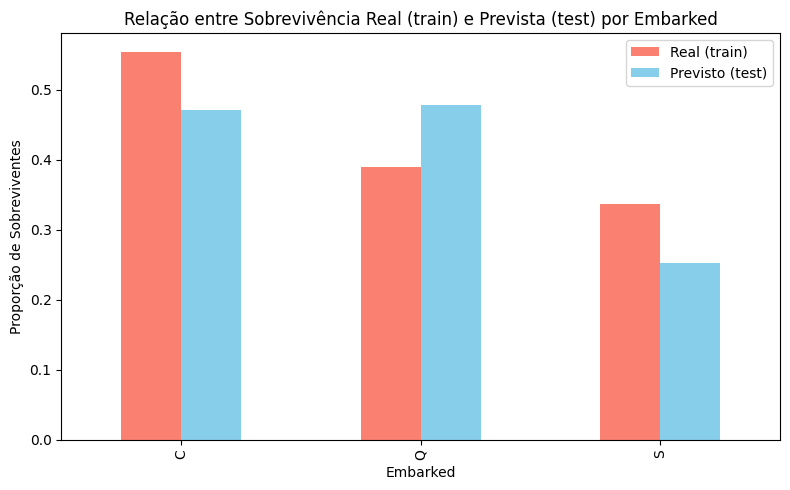

In [44]:
# Avaliação no conjunto de teste usando modelo TensorFlow
test_df = pd.read_csv("test.csv")
X_test = test_df[features].copy()
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked'], drop_first=True)
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())

# Garante que as colunas de X_test estejam alinhadas com o treino
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X_train.columns]

X_test_scaled = scaler.transform(X_test)

# Previsão no conjunto de teste
y_test_pred_proba = model.predict(X_test_scaled).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Exibindo as previsões
test_df['Predicted_Survived'] = y_test_pred

# Plotando distribuição de probabilidades
plt.figure(figsize=(8,5))
plt.hist(y_test_pred_proba, bins=20, color='skyblue', edgecolor='black')
plt.title('Quantidade de pessoas por probabilidade de sobrevivência (Teste)')
plt.xlabel('Probabilidade de Sobrevivência')
plt.ylabel('Quantidade de pessoas')
plt.tight_layout()
plt.show()

# Plotando relação entre 'Predicted_Survived' e cada feature
for feature in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']:
    plt.figure(figsize=(8,5))
    # Proporção de sobreviventes prevista (teste)
    pred = test_df.groupby(feature)['Predicted_Survived'].mean()
    # Proporção de sobreviventes real (treino)
    real = train_df.groupby(feature)['Survived'].mean()
    df_plot = pd.DataFrame({'Real (train)': real, 'Previsto (test)': pred})
    df_plot.plot(kind='bar', ax=plt.gca(), color=['salmon', 'skyblue'])
    plt.ylabel('Proporção de Sobreviventes')
    plt.title(f'Relação entre Sobrevivência Real (train) e Prevista (test) por {feature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

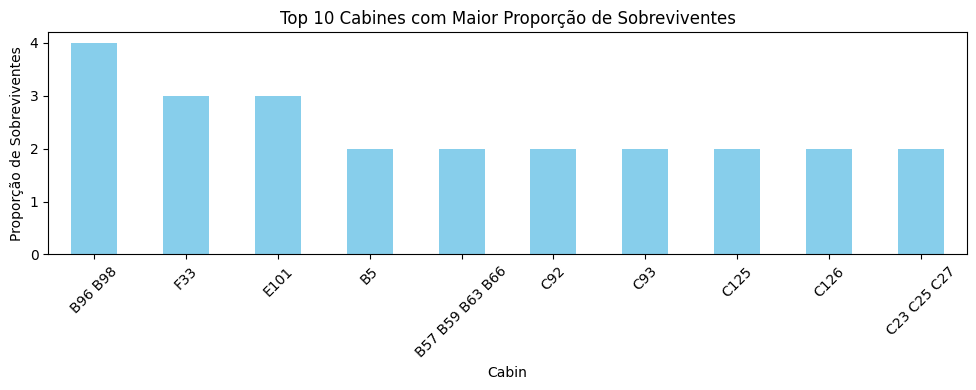

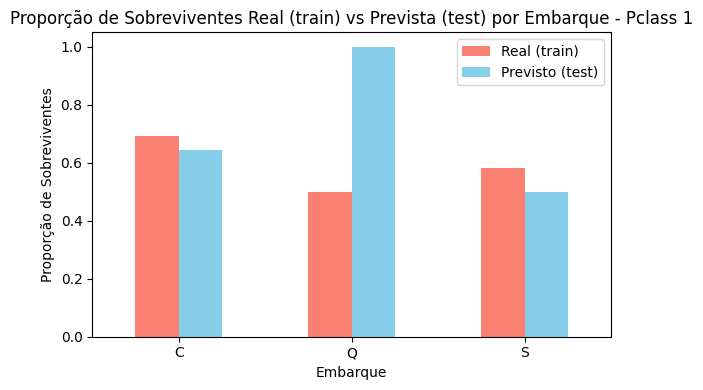

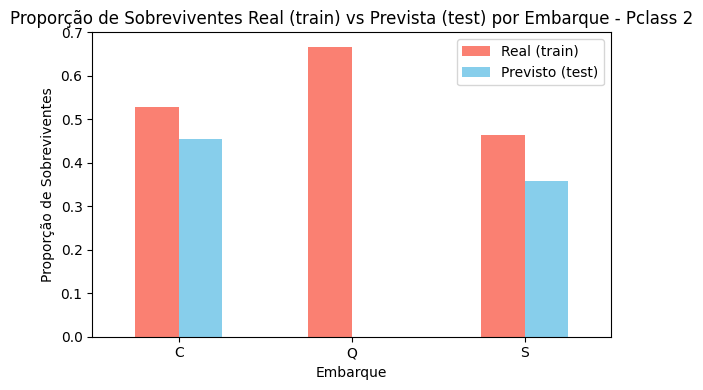

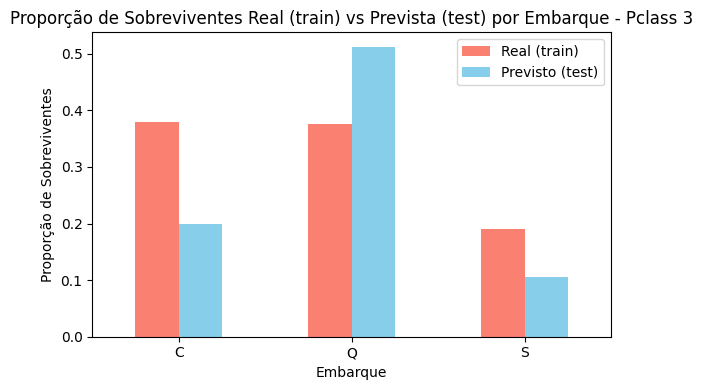

/tmp/ipython-input-45-511141288.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')


<Figure size 800x500 with 0 Axes>

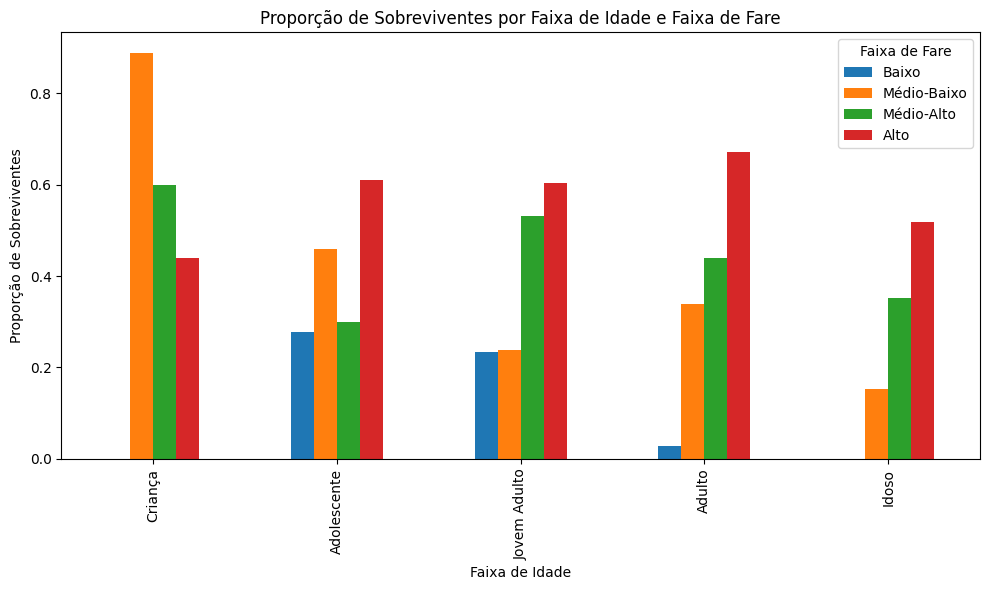

In [45]:
# Análise: Cabines com mais sobreviventes (apenas real)
cabine_surv = train_df.groupby('Cabin')['Survived'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
cabine_surv.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cabines com Maior Proporção de Sobreviventes')
plt.xlabel('Cabin')
plt.ylabel('Proporção de Sobreviventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análise: Embarque com mais sobreviventes por Pclass (real vs previsto)
for pclass in sorted(train_df['Pclass'].unique()):
    real_emb = train_df[train_df['Pclass']==pclass].groupby('Embarked')['Survived'].mean().sort_index()
    plt.figure(figsize=(6,4))
    if 'Predicted_Survived' in test_df.columns:
        pred_emb = test_df[test_df['Pclass']==pclass].groupby('Embarked')['Predicted_Survived'].mean().reindex(real_emb.index)
        df_emb = pd.DataFrame({'Real (train)': real_emb, 'Previsto (test)': pred_emb})
        df_emb.plot(kind='bar', ax=plt.gca(), color=['salmon', 'skyblue'])
        plt.title(f'Proporção de Sobreviventes Real (train) vs Prevista (test) por Embarque - Pclass {pclass}')
    else:
        real_emb.plot(kind='bar', color='salmon')
        plt.title(f'Proporção de Sobreviventes por Embarque - Pclass {pclass} (Real)')
    plt.xlabel('Embarque')
    plt.ylabel('Proporção de Sobreviventes')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Análise: Faixas de Fare e Ages que mais sobreviveram (apenas real)
fare_bins = pd.qcut(train_df['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
age_bins = pd.cut(train_df['Age'], bins=[0,12,18,30,50,80], labels=['Criança','Adolescente','Jovem Adulto','Adulto','Idoso'])
fare_age_surv = train_df.copy()
fare_age_surv['FareBin'] = fare_bins
fare_age_surv['AgeBin'] = age_bins
plt.figure(figsize=(8,5))
surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')
surv_pivot.plot(kind='bar', figsize=(10,6))
plt.title('Proporção de Sobreviventes por Faixa de Idade e Faixa de Fare')
plt.ylabel('Proporção de Sobreviventes')
plt.xlabel('Faixa de Idade')
plt.legend(title='Faixa de Fare')
plt.tight_layout()
plt.show()

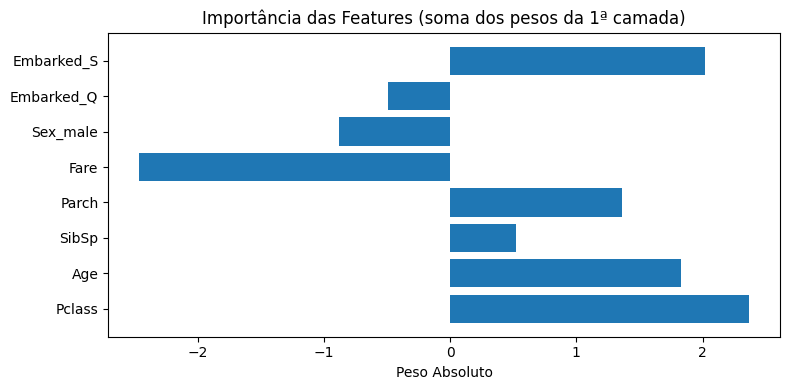

In [48]:
# Importância das features usando modelo TensorFlow
importances = model.layers[0].get_weights()[0].sum(axis=1)
feature_names = X_train.columns
plt.figure(figsize=(8,4))
plt.barh(feature_names, importances)
plt.title('Importância das Features (soma dos pesos da 1ª camada)')
plt.xlabel('Peso Absoluto')
plt.tight_layout()
plt.show()

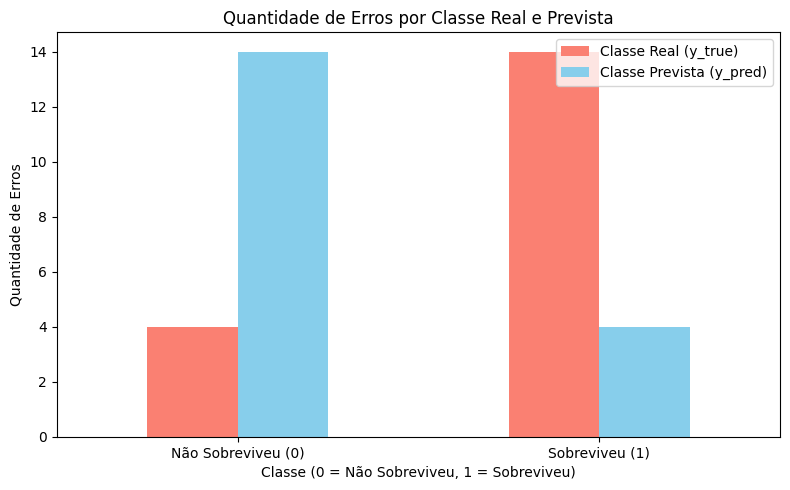

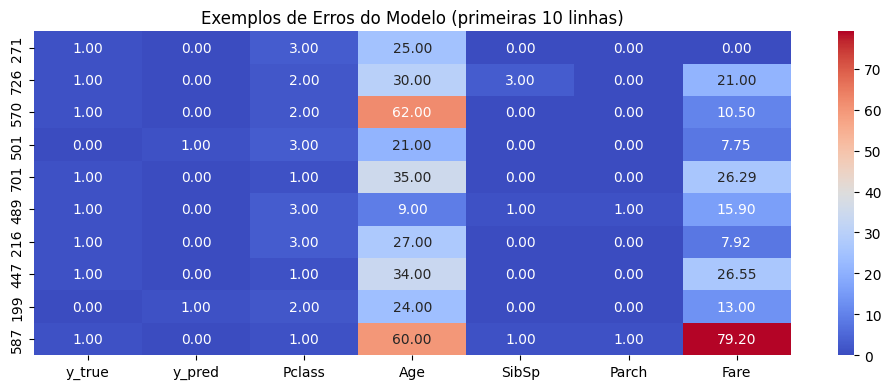

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análise dos erros do modelo com plot
val_results = X_val.copy()
val_results['y_true'] = y_val.values
val_results['y_pred'] = val_pred
val_results['erro'] = val_results['y_true'] != val_results['y_pred']

# Unindo os dois gráficos em um só
erro_real = val_results[val_results['erro']].groupby('y_true').size()
erro_pred = val_results[val_results['erro']].groupby('y_pred').size()
df_erro = pd.DataFrame({'Classe Real (y_true)': erro_real, 'Classe Prevista (y_pred)': erro_pred})

df_erro.plot(kind='bar', color=['salmon', 'skyblue'], figsize=(8,5))
plt.title('Quantidade de Erros por Classe Real e Prevista')
plt.xlabel('Classe (0 = Não Sobreviveu, 1 = Sobreviveu)')
plt.ylabel('Quantidade de Erros')
plt.xticks([0,1], ['Não Sobreviveu (0)', 'Sobreviveu (1)'], rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap dos erros (mantido igual)
cols_to_show = ['y_true', 'y_pred']
for col in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    if col in val_results.columns:
        cols_to_show.append(col)

heatmap_data = val_results[val_results['erro']].head(10)[cols_to_show].astype(float)

plt.figure(figsize=(10,4))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Exemplos de Erros do Modelo (primeiras 10 linhas)')
plt.tight_layout()
plt.show()

### Referências bibliográficas

- KAGGLE. Titanic - Machine Learning from Disaster. Disponível em: <https://www.kaggle.com/c/titanic>. Acesso em: 04 jul. 2025.

- TAVARES, Lucas. Dados desbalanceados: o que são e como evitá-los. *Turing Talks*, Medium, 2020. Disponível em: <https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b>. Acesso em: 04 jul. 2025.

- Pandas: Python Data Analysis Library. Disponível em: <https://pandas.pydata.org/>. Acesso em: 04 jul. 2025.

- Scikit-learn: Machine Learning in Python. Disponível em: <https://scikit-learn.org/stable/>. Acesso em: 04 jul. 2025.